#Import Library yang digunakan



In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

#Load Data dan Prepocessing Data

In [23]:
#Load Dataset

url = "/content/grab_review.csv"
df = pd.read_csv(url)

df.head()

,id,nama,rating,tanggal,Review
0,4208ac26-4cb5-4af1-9bde-5cb93308442e,Pengguna Google,5,2025-10-25 00:52:28,sangat cepett dan amann
1,526d8d87-c48a-47fa-9e5e-83a109ef7120,Pengguna Google,5,2025-10-25 00:49:54,baik
2,788d781b-35e4-433e-8a7a-0f7189d22829,Pengguna Google,5,2025-10-25 00:43:07,semoga menjadi driver yg amanah😊
3,db017495-bac6-482d-a81e-2657b59daef2,Pengguna Google,3,2025-10-25 00:13:00,baiknya hapus penggunaan foto ai yg untuk menu...
4,3c1d519d-4597-41b3-8283-eaa7d378ff96,Pengguna Google,5,2025-10-24 23:58:14,Sangat Memuaskan terima kasih


In [24]:
# Hapus Kolom yang tidak digunakan
df = df.drop(columns=['id'])
print(df.columns)

Index(['nama', 'rating', 'tanggal', 'Review'], dtype='object')


In [25]:
# Cek Missing data dan ringkasan dataframe info
missing = df.isna().sum()
print(missing)

df.info()

nama       0
rating     0
tanggal    0
Review     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nama     10000 non-null  object
 1   rating   10000 non-null  int64 
 2   tanggal  10000 non-null  object
 3   Review   10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


In [26]:
#Labelling sentimen menggunakan rating
def label_sentiment(score):
    if score >= 4:
        return "positif"
    elif score == 3:
        return "netral"
    else:
        return "negatif"

df['sentimen'] = df['rating'].apply(label_sentiment)
df.head()


,nama,rating,tanggal,Review,sentimen
0,Pengguna Google,5,2025-10-25 00:52:28,sangat cepett dan amann,positif
1,Pengguna Google,5,2025-10-25 00:49:54,baik,positif
2,Pengguna Google,5,2025-10-25 00:43:07,semoga menjadi driver yg amanah😊,positif
3,Pengguna Google,3,2025-10-25 00:13:00,baiknya hapus penggunaan foto ai yg untuk menu...,netral
4,Pengguna Google,5,2025-10-24 23:58:14,Sangat Memuaskan terima kasih,positif


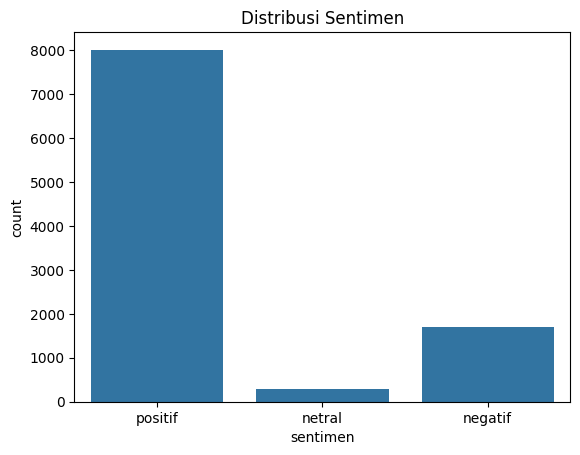

In [27]:
# Lihat Sebaran sentimen
sns.countplot(x='sentimen', data=df)
plt.title("Distribusi Sentimen")
plt.show()

In [28]:
# Inisialisasi daftar sentimen
label_num = []

# Iterasi setiap baris dalam DataFrame
for index, row in df.iterrows():
    if row['rating'] > 3 :
        label_num.append(1)     # nilai 1 untuk score 4 - 5
    elif row['rating'] == 3:
        label_num.append(0)     # nilai 0 untuk score 3
    else:
        label_num.append(-1)    # nilai -1 untuk score 1 - 2

# Tambahkan kolom baru
df['label_num'] = label_num
df.head()

,nama,rating,tanggal,Review,sentimen,label_num
0,Pengguna Google,5,2025-10-25 00:52:28,sangat cepett dan amann,positif,1
1,Pengguna Google,5,2025-10-25 00:49:54,baik,positif,1
2,Pengguna Google,5,2025-10-25 00:43:07,semoga menjadi driver yg amanah😊,positif,1
3,Pengguna Google,3,2025-10-25 00:13:00,baiknya hapus penggunaan foto ai yg untuk menu...,netral,0
4,Pengguna Google,5,2025-10-24 23:58:14,Sangat Memuaskan terima kasih,positif,1


/tmp/ipython-input-3333432200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='coolwarm')


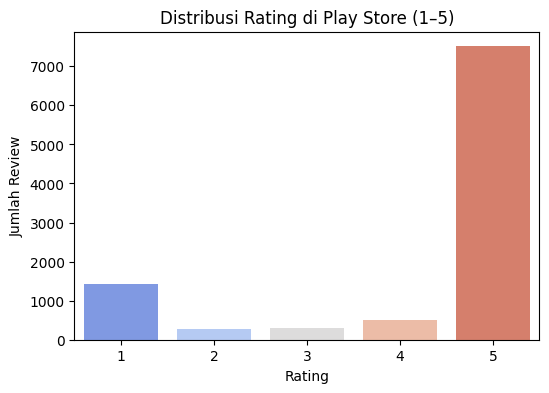

In [29]:
# Cek distribusi Rating
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, palette='coolwarm')
plt.title("Distribusi Rating di Play Store (1–5)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()


#Preprocessing Teks

In [30]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stopword_id = set(stopwords.words('indonesian'))

def cleaning(teks):

    teks = str(teks).lower()                   # ubah ke huruf kecil
    teks = re.sub(r'[^a-z\s]', ' ', teks)      # hapus karakter non-huruf
    teks = re.sub(r'\s+', ' ', teks).strip()   # rapikan spasi
    hasil = [kata for kata in teks.split() if kata not in stopword_id]
    return ' '.join(hasil)

# Terapkan fungsi pada kolom 'Review'
df['Clean_Review'] = df['Review'].apply(cleaning)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,nama,rating,tanggal,Review,sentimen,label_num,Clean_Review
0,Pengguna Google,5,2025-10-25 00:52:28,sangat cepett dan amann,positif,1,cepett amann
1,Pengguna Google,5,2025-10-25 00:49:54,baik,positif,1,
2,Pengguna Google,5,2025-10-25 00:43:07,semoga menjadi driver yg amanah😊,positif,1,semoga driver yg amanah
3,Pengguna Google,3,2025-10-25 00:13:00,baiknya hapus penggunaan foto ai yg untuk menu...,netral,0,baiknya hapus penggunaan foto ai yg menu hidan...
4,Pengguna Google,5,2025-10-24 23:58:14,Sangat Memuaskan terima kasih,positif,1,memuaskan terima kasih


In [31]:
# Tokenisasi
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')
df['Review_Tokenization']=df['Clean_Review'].apply(regexp.tokenize)
df

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-613781563.py:4: SyntaxWarning: invalid escape sequence '\w'
  regexp = RegexpTokenizer('\w+')


,nama,rating,tanggal,Review,sentimen,label_num,Clean_Review,Review_Tokenization
0,Pengguna Google,5,2025-10-25 00:52:28,sangat cepett dan amann,positif,1,cepett amann,"[cepett, amann]"
1,Pengguna Google,5,2025-10-25 00:49:54,baik,positif,1,,[]
2,Pengguna Google,5,2025-10-25 00:43:07,semoga menjadi driver yg amanah😊,positif,1,semoga driver yg amanah,"[semoga, driver, yg, amanah]"
3,Pengguna Google,3,2025-10-25 00:13:00,baiknya hapus penggunaan foto ai yg untuk menu...,netral,0,baiknya hapus penggunaan foto ai yg menu hidan...,"[baiknya, hapus, penggunaan, foto, ai, yg, men..."
4,Pengguna Google,5,2025-10-24 23:58:14,Sangat Memuaskan terima kasih,positif,1,memuaskan terima kasih,"[memuaskan, terima, kasih]"
...,...,...,...,...,...,...,...,...
9995,didik hernadi,5,2025-08-02 11:51:31,mantap,positif,1,mantap,[mantap]
9996,Aisah,5,2025-08-02 11:31:12,bagus,positif,1,bagus,[bagus]
9997,Rudy Piterson Blake,5,2025-08-02 11:19:14,Mantapppp,positif,1,mantapppp,[mantapppp]
9998,Iwan Rahmat,5,2025-08-02 11:18:08,Its ok,positif,1,its ok,"[its, ok]"


#Modelling

In [44]:
# Membagi X dan y untuk melatih model
X = df['Clean_Review'].astype(str)
y = df['label_num']

# Encode label agar label numnya positif
le = LabelEncoder()
y = le.fit_transform(y)

# Disini akan dilakukan shuffle agar distribusinya acak dan merata
X, y = shuffle(X, y, random_state=42)


##SVM + TF-idf (80/20)

In [45]:
print("SVM + TF-IDF (80/20)")


#Disini kita akan download stopword untuk bahasa indonesia
nltk.download('stopwords')

stop_words_id = stopwords.words('indonesian')

# Kita akan melakukan splitting data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Disini kita akan buat model tfidf yang sudah saya tuning dengan max features 2000 dan tuning lainnya
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    smooth_idf=True,
    norm='l2',
    stop_words=stop_words_id
)
# Terapkan model tf idf ke X_Train
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Buat juga model SVM
svm = SVC(
    kernel='rbf',
    C=3.0,
    gamma='scale',
    class_weight='balanced',
    probability=False,
    random_state=42
)

# Latih model yang sudah dibuat oleh TF-IDF dengan SVM
svm.fit(X_train_tfidf, y_train)

# Hitung akurasi saat training dan testing data
train_acc = svm.score(X_train_tfidf, y_train)
test_acc = svm.score(X_test_tfidf, y_test)

print(f"Akurasi Training : {train_acc*100:.2f}%")
print(f"Akurasi Testing  : {test_acc*100:.2f}%")

# Evaluasi hasil prediksi
y_pred_svm = svm.predict(X_test_tfidf)

print("Report")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_.astype(str)))


SVM + TF-IDF (80/20)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Akurasi Training : 98.08%
Akurasi Testing  : 89.75%
Report
              precision    recall  f1-score   support

          -1       0.72      0.85      0.78       339
           0       0.03      0.02      0.02        59
           1       0.96      0.94      0.95      1602

    accuracy                           0.90      2000
   macro avg       0.57      0.60      0.58      2000
weighted avg       0.89      0.90      0.89      2000



##RF+Word2Vec

RF + Word2Vec
Akurasi Training : 97.97%
Akurasi Testing  : 89.75%
Report
              precision    recall  f1-score   support

          -1       0.72      0.85      0.78       339
           0       0.00      0.00      0.00        59
           1       0.96      0.94      0.95      1602

    accuracy                           0.90      2000
   macro avg       0.56      0.60      0.58      2000
weighted avg       0.89      0.90      0.89      2000



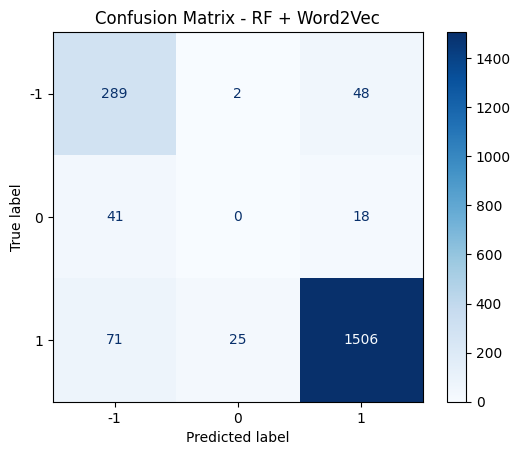

In [46]:

print("RF + Word2Vec")

# Disini saya melakukan Tokenisasi sederhana
sentences = [text.split() for text in X]

# Disini saya membuat model word 2 vec yang sudah saya tuning agar mendapatkan hasil optimal
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=250,
    window=8,
    min_count=2,
    sg=1,
    negative=15,
    epochs=20,
    workers=4,
    seed=42
)

# disini saya membuat fungsi sentence vector untuk mengubah kaliumat vector ke kalimat rata rata vector
def sentence_vector(tokens, model):
    valid_words = [w for w in tokens if w in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_words], axis=0)

# Ubah semua kalimat jadi vektor Word2Vec
X_vectors = np.array([sentence_vector(s, w2v_model) for s in sentences])

# Melakukan splitting data yakni 80/20
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, random_state=42, stratify=y
)

# Buat model random forest yang sudah saya tuning
rf_w2v = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# Latih model dengan rf+w2v
rf_w2v.fit(X_train_vec, y_train)

# Evaluasi akurasi train vs test
train_acc = rf_w2v.score(X_train_vec, y_train)
test_acc = rf_w2v.score(X_test_vec, y_test)

print(f"Akurasi Training : {train_acc*100:.2f}%")
print(f"Akurasi Testing  : {test_acc*100:.2f}%")

# Prediksi ==
y_pred_rf_w2v = rf_w2v.predict(X_test_vec)

print("Report")
print(classification_report(y_test, y_pred_rf_w2v, target_names=le.classes_.astype(str)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf_w2v)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - RF + Word2Vec")
plt.show()

##RF+TF-IDF (70/30)

In [47]:
print("RF + TF-IDF (70/30)")

stop_words_id = stopwords.words('indonesian')

# Split data menjadi 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Buat model tdidf2 yang sudah saya tuning
tfidf2 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    smooth_idf=True,
    norm='l2',
    stop_words=stop_words_id
)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2 = tfidf2.transform(X_test)

# Buat model random forest yang sudah saya tuning
rf_tfidf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_tfidf.fit(X_train_tfidf2, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf2)

# Evaluasi hasil
acc_train = rf_tfidf.score(X_train_tfidf2, y_train)
acc_test = rf_tfidf.score(X_test_tfidf2, y_test)

print(f"Akurasi Training : {acc_train*100:.2f}%")
print(f"Akurasi Testing  : {acc_test*100:.2f}%")
print(classification_report(y_test, y_pred_rf_tfidf, target_names=le.classes_.astype(str)))

RF + TF-IDF (70/30)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Akurasi Training : 91.57%
Akurasi Testing  : 88.13%
              precision    recall  f1-score   support

          -1       0.74      0.63      0.68       509
           0       0.19      0.15      0.17        88
           1       0.93      0.96      0.94      2403

    accuracy                           0.88      3000
   macro avg       0.62      0.58      0.60      3000
weighted avg       0.87      0.88      0.88      3000

